# 1. Load dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
from sklearn.model_selection import train_test_split

# File paths
myanmar_file_path = './app/dataset/data_myn.txt'
english_file_path = './app/dataset/data_eng.txt'

# Read the files
with open(myanmar_file_path, 'r', encoding='utf-8') as myfile:
    myanmar_lines = myfile.readlines()

with open(english_file_path, 'r', encoding='utf-8') as engfile:
    english_lines = engfile.readlines()

# Pair the lines
paired_lines = list(zip(myanmar_lines, english_lines))

#### clean the words

In [3]:
import re

def clean_text(text):
    
    # Remove numerical indices, tabs, and special characters except alphabetic and spaces
    cleaned_text = re.sub('[^A-Za-z0-9က-၏ဠ-ဿ၀-၉၊။ ]+', '', text)
    cleaned_text = re.sub('\d+', '', cleaned_text)
    return cleaned_text.strip()

In [4]:
cleaned_data = {(clean_text(myanmar), clean_text(english)) for myanmar, english in paired_lines}

### converting to panda dataframe

In [5]:
import pandas as pd
df = pd.DataFrame(cleaned_data, columns=['Myanmar', 'English'])
df[:5]

,Myanmar,English
0,နိုင်ငံခြားသားနဲ့ စကားပြောရတာ ပျော်ဖို့ကောင်းတယ်။,It is very fun to talk with foreigners
1,ကျွန်တော့်ဘေးမှာ ထားထားတဲ့ အိတ်ကို မစ္စတာမဆုအိ...,I gave the bag to Mr Matsui that was near me
2,ကျွန်တော် ဝက်သား မစားနိုင်ဘူး။,I cannot eat pork
3,ဟို အရပ်ပုပုနဲ့လူက မစ္စတာခိမုရပါ။,That short person is Ms Kimura
4,ဆရာက မေးခွန်းထုတ်လိုက်ပါတယ်။,The teacher asked a question


In [6]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [8]:
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)


### after spliting train, test and valid dataset, then uploaded to hugging face and download it

In [9]:
import datasets

en_my_corpus = datasets.load_dataset('KaungHtetCho/MT-myanmar-english')

/home/koala/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
en_my_corpus

DatasetDict({
    train: Dataset({
        features: ['Myanmar', 'English'],
        num_rows: 1093
    })
    validation: Dataset({
        features: ['Myanmar', 'English'],
        num_rows: 137
    })
    test: Dataset({
        features: ['Myanmar', 'English'],
        num_rows: 137
    })
})

In [11]:
train_size      = len(en_my_corpus['train'])
validation_size = len(en_my_corpus['validation'])
test_size       = len(en_my_corpus['test'])

print('train_size: ', train_size)
print('test_size: ', test_size)
print('validation_size: ', validation_size)

train_size:  1093
test_size:  137
validation_size:  137


# 2. Preprocessing

### Tokenization

In [12]:
token_transform = {}
vocab_transform = {}

In [13]:
SRC_LANGUAGE = 'English'
TRG_LANGUAGE = 'Myanmar'

In [14]:
import pyidaungsu as pds
my_tokenizer = pds.tokenize

In [81]:
tokenized_word = pds.tokenize("ကောင်းထက်ချို၏ကျေးဇူးတရားမှာကြီးမားလှပေသည်", form="word")
print(tokenized_word)

['ကောင်း', 'ထက်', 'ချို', '၏', 'ကျေးဇူးတရား', 'မှာ', 'ကြီးမား', 'လှ', 'ပေ', 'သည်']


In [15]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = my_tokenizer

In [16]:
print('source language (English): ', en_my_corpus['train'][5][SRC_LANGUAGE])

print('target language (Myanmar): ', en_my_corpus['train'][5][TRG_LANGUAGE])

source language (English):  Mr Tanaka is doing a hard job
target language (Myanmar):  မစ္စတာတာနာခါက ပင်ပန်းတဲ့အလုပ်တွေ လုပ်နေတယ်။


In [17]:
import copy
tokenized_corpus = copy.deepcopy(en_my_corpus)

In [18]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Build vocabs

In [19]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    if data is None:
        return []
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        if isinstance(data_sample, list):
            yield token_transform[language](data_sample[language_index[language]])
        elif isinstance(data_sample, dict):
            yield token_transform[language](data_sample[language])

In [20]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(tokenized_corpus['train'], ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [21]:
import pickle

pickle.dump(vocab_transform, open('./app/data/vocab.pkl', 'wb'))

In [22]:
vocab_transform = pickle.load(open('./app/data/vocab.pkl', 'rb'))

In [23]:
vocab_transform

{'English': Vocab(), 'Myanmar': Vocab()}

### Preparing the data loader

In [24]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        if txt_input is None:
            return []
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tensors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for lang_data in batch:
        for lang, tokens in lang_data.items():
            processed_text = text_transform[lang](tokens) if tokens else torch.empty(0, dtype=torch.int64)
            if lang == SRC_LANGUAGE:
                src_batch.append(processed_text)
                src_len_batch.append(processed_text.size(0))
            elif lang == TRG_LANGUAGE:
                trg_batch.append(processed_text)
                
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear
    # print('src_batch', src_batch.shape

    # Set the length of empty sequences to the maximum length
    max_len = max(src_batch.size(0), max(src_len_batch))
    # print('max_length: ', max_len)
    src_len_batch = [length if length > 0 else max_len for length in src_len_batch]
    # print('src_len_batch', src_len_batch)

    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)

    print
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [25]:
batch_size = BATCH_SIZE

train_loader = DataLoader(tokenized_corpus['train'], batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(tokenized_corpus['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(tokenized_corpus['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# train_loader = DataLoader(corpus_test, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)

In [26]:
print(text_transform)
print(vocab_transform)


{'English': <function sequential_transforms.<locals>.func at 0x7fd50eed1ee0>, 'Myanmar': <function sequential_transforms.<locals>.func at 0x7fd50eed1f80>}
{'English': Vocab(), 'Myanmar': Vocab()}


In [27]:
print(len(train_loader))
print(len(test_loader))
print(len(test_loader))

18
3
3


In [28]:
for en, _, my in train_loader:
    break

In [29]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("Myanmar shape: ", my.shape)   # (seq len, batch_size)

English shape:  torch.Size([64, 15])
Myanmar shape:  torch.Size([64, 24])


# 3. Design the model

### Position-wise feedforward layer

In [30]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Encoder
- Encoder layer

In [31]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = attention(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        # print(src.shape, _src.shape)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        # print(src.shape)
        #src: [batch_size, src len, hid dim]
        
        return src

- Encoder 

In [32]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, 
                 attention, max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        # print(src.shape)
        return src

### Decoder
- Decoder layer

In [33]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = attention(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = attention(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        # print(trg.shape, enc_src.shape)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

- Decoder

In [34]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, attention, max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        # print(trg.shape, self.scale, self.tok_embedding, self.pos_embedding)
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Attention mechanisms
- general attention

In [35]:
class generalAttention(nn.Module):  # to get more complex relationship
    def __init__(self, hid_dim, n_heads, dropout, device):

        super().__init__()

        assert hid_dim % n_heads == 0 # to make sure head are divisible

        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads  # dk
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim) # why 2 dimensions (pass through fully connect layers)
        self.fc_k     = nn.Linear(hid_dim, hid_dim) 
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim) # final concat layer
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None): # they're src tokens

        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        # print("Before reshape - Q size:", Q.size())
        K = self.fc_k(key)
        # print("Before reshape - K size:", K.size())
        V = self.fc_v(value)
        # print("Before reshape - V size:", V.size())

        #Q=K=V: [batch_size, src len, hid_dim]
        # project to neural networks (backpropagation will take care of that)
        
        # chop them
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) #change dimensions 
        # print("After reshape - Q size:", Q.size())
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # print("After reshape - K size:", K.size())
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # print("After reshape - V size:", V.size())

        #Q = [batch_size, n heads, query len, head_dim]
        # k_permute = K.permute(0, 1, 3, 2)
        # print('k permute: ', k_permute.shape)
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale # dk
        

        # print('energy shape: ', energy.shape)
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        # print('mask shape: ', mask.shape)
        
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim) # concatenation
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]        
        return x, attention

- multiplicative attention

In [36]:
class multiplicativeAttention(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        #Additional linear layer for the multiplicative attention mechanism
        self.fc_w = nn.Linear(self.head_dim, self.head_dim)

        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)


        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        K_transformed = self.fc_w(K)
        
        # Scaled Multiplicative Attention
        
        # Q @ W @ KT (W is weight with d2 x d1 dimension [head_dim, head_dim])
        energy = torch.matmul(Q, K_transformed.transpose(-2, -1)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]

        # print(energy.shape)
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

- additive attention

In [37]:
class additiveAttention(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        # W1 and W2 for the additive attention mechanism
        self.fc_w1 = nn.Linear(self.head_dim, self.head_dim)
        self.fc_w2 = nn.Linear(self.head_dim, self.head_dim)
        
        # va for the additive attention mechanism
        self.fc_va = nn.Linear(self.head_dim, 1)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        batch_size = query.shape[0]
        # Linear transformations
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Split into n_heads
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # print('V: ', V.shape)
        # Apply W1 and W2 transformations for additive attention
        Q_transformed = self.fc_w1(Q)
        K_transformed = self.fc_w2(K)

        # print('Q_transfomed: ', Q_transformed.shape)
        # print('K_transfomed: ', K_transformed.shape)
        # Q,K_transformed: batch_size, n-heads, key_len, query_len
        

        Q_expanded = Q_transformed.unsqueeze(3)  # [batch_size, n_heads, query_len, 1, head_dim]

        # print('Q_expanded: unsqueeze(3) ', Q_expanded.shape)
        K_expanded = K_transformed.unsqueeze(2)  # [batch_size, n_heads, 1, key_len, head_dim]
        # print('K_expanded: unsqueeze(2) ', K_expanded.shape)

        qk = torch.tanh(Q_expanded + K_expanded)
        # print('qk: ', qk.shape)
        before_energy = self.fc_va(torch.tanh(Q_expanded + K_expanded))
        # print("energy before squeeze: ", before_energy.shape)
        # print('qk: ',qk.shape)
        #batch_size, n-heads, key_len, query_len
        # Compute additive attention scores
        energy = self.fc_va(torch.tanh(Q_expanded + K_expanded)).squeeze(-1)  # [batch_size, n_heads, query_len, key_len]
        #energy = batch_size, n-heads, key_len, query_len @ n-heads, 1
        # print('energy shape after squeeze: ', energy.shape)
        
        #for making attention to padding to 0
        if mask is not None:
            # print(energy.shape, mask.shape)
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        return x, attention

### Seq2seq

In [38]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# 4. Training

In [39]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [40]:
def initialize_model(model_name):

    if model_name == 'general_attention':
        attention_model = generalAttention
    elif model_name == 'multiplicative_attention':
        attention_model = multiplicativeAttention
    elif model_name == 'additive_attention':
        attention_model = additiveAttention

    input_dim   = len(vocab_transform[SRC_LANGUAGE])
    output_dim  = len(vocab_transform[TRG_LANGUAGE])
    hid_dim = 256
    enc_layers = 3
    dec_layers = 3
    enc_heads = 8
    dec_heads = 8
    enc_pf_dim = 512
    dec_pf_dim = 512
    enc_dropout = 0.1
    dec_dropout = 0.1

    SRC_PAD_IDX = PAD_IDX
    TRG_PAD_IDX = PAD_IDX

    enc = Encoder(input_dim, 
                hid_dim, 
                enc_layers, 
                enc_heads, 
                enc_pf_dim, 
                enc_dropout, 
                device,
                attention_model)

    dec = Decoder(output_dim, 
                hid_dim, 
                dec_layers, 
                dec_heads, 
                dec_pf_dim, 
                enc_dropout, 
                device,
                attention_model)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    return model

In [41]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [42]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [43]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [44]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### - general attention

In [46]:
model = initialize_model("general_attention")

# hyperparameters
lr = 0.0001
optimizer_gen = optim.Adam(model.parameters(), lr=lr)
criterion_gen = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

print(count_parameters(model))

196096
256000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
136448
256000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
136448
   533
______
4935189
None


In [47]:
best_valid_loss = float('inf')
best_train_loss = float('inf')
best_train_ppl  = float('inf')
best_valid_ppl  = float('inf')

num_epochs = 100
clip = 1
save_path = './app/models/general_attention.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer_gen, criterion_gen, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion_gen, val_loader_length)
    
    # For plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_ppl = train_ppl
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_ppl = valid_ppl
        torch.save(model.state_dict(), save_path)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

print(f'Best Train Loss: {best_train_loss:.3f} | Best Train PPL: {best_train_ppl:7.3f}')
print(f'Best Val. Loss: {best_valid_loss:.3f} | Best Val. PPL: {best_valid_ppl:7.3f}')

Epoch: 01 | Time: 0m 0s
	Train Loss: 5.656 | Train PPL: 286.056
	 Val. Loss: 5.227 |  Val. PPL: 186.212
Epoch: 02 | Time: 0m 0s
	Train Loss: 5.071 | Train PPL: 159.388
	 Val. Loss: 4.735 |  Val. PPL: 113.829
Epoch: 03 | Time: 0m 0s
	Train Loss: 4.669 | Train PPL: 106.582
	 Val. Loss: 4.469 |  Val. PPL:  87.281
Epoch: 04 | Time: 0m 0s
	Train Loss: 4.425 | Train PPL:  83.539
	 Val. Loss: 4.288 |  Val. PPL:  72.821
Epoch: 05 | Time: 0m 0s
	Train Loss: 4.252 | Train PPL:  70.234
	 Val. Loss: 4.125 |  Val. PPL:  61.870
Epoch: 06 | Time: 0m 0s
	Train Loss: 4.098 | Train PPL:  60.207
	 Val. Loss: 4.009 |  Val. PPL:  55.087
Epoch: 07 | Time: 0m 0s
	Train Loss: 3.966 | Train PPL:  52.773
	 Val. Loss: 3.898 |  Val. PPL:  49.287
Epoch: 08 | Time: 0m 0s
	Train Loss: 3.803 | Train PPL:  44.852
	 Val. Loss: 3.791 |  Val. PPL:  44.292
Epoch: 09 | Time: 0m 0s
	Train Loss: 3.706 | Train PPL:  40.701
	 Val. Loss: 3.700 |  Val. PPL:  40.438
Epoch: 10 | Time: 0m 0s
	Train Loss: 3.570 | Train PPL:  35.533


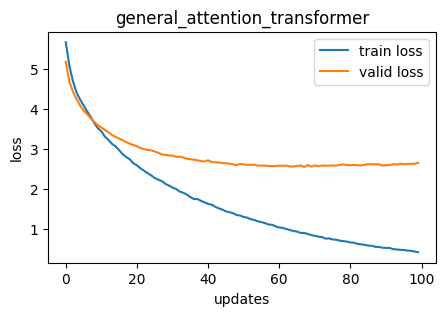

In [95]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
ax.set_title('general_attention_transformer')

filename = './app/images/general_attention_transformer_loss_plot.png'

# Save the figure
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')

In [49]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion_gen, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.639 | Test PPL:  14.004 |


#### - multiplicative attention

In [50]:
model = initialize_model("multiplicative_attention")

#training hyperparameters
lr = 0.0001
optimizer_multi = optim.Adam(model.parameters(), lr=lr)
criterion_multi = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

print(count_parameters(model))

196096
256000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
136448
256000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536

In [51]:
best_valid_loss = float('inf')
best_train_loss = float('inf')
best_train_ppl  = float('inf')
best_valid_ppl  = float('inf')

num_epochs = 100
clip = 1
save_path = './app/models/multiplicative_attention.pt'

train_losses = []
valid_losses = []


for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer_multi, criterion_multi, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion_multi, val_loader_length)
    
    # For plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_ppl = train_ppl
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_ppl = valid_ppl
        torch.save(model.state_dict(), save_path)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

print(f'Best Train Loss: {best_train_loss:.3f} | Best Train PPL: {best_train_ppl:7.3f}')
print(f'Best Val. Loss: {best_valid_loss:.3f} | Best Val. PPL: {best_valid_ppl:7.3f}')

Epoch: 01 | Time: 0m 0s
	Train Loss: 5.643 | Train PPL: 282.257
	 Val. Loss: 5.180 |  Val. PPL: 177.754
Epoch: 02 | Time: 0m 0s
	Train Loss: 5.084 | Train PPL: 161.456
	 Val. Loss: 4.709 |  Val. PPL: 110.900
Epoch: 03 | Time: 0m 0s
	Train Loss: 4.678 | Train PPL: 107.595
	 Val. Loss: 4.463 |  Val. PPL:  86.752
Epoch: 04 | Time: 0m 0s
	Train Loss: 4.426 | Train PPL:  83.630
	 Val. Loss: 4.293 |  Val. PPL:  73.164
Epoch: 05 | Time: 0m 0s
	Train Loss: 4.227 | Train PPL:  68.516
	 Val. Loss: 4.155 |  Val. PPL:  63.735
Epoch: 06 | Time: 0m 0s
	Train Loss: 4.113 | Train PPL:  61.154
	 Val. Loss: 4.015 |  Val. PPL:  55.416
Epoch: 07 | Time: 0m 0s
	Train Loss: 3.979 | Train PPL:  53.443
	 Val. Loss: 3.906 |  Val. PPL:  49.696
Epoch: 08 | Time: 0m 0s
	Train Loss: 3.821 | Train PPL:  45.628
	 Val. Loss: 3.809 |  Val. PPL:  45.086
Epoch: 09 | Time: 0m 0s
	Train Loss: 3.681 | Train PPL:  39.703
	 Val. Loss: 3.738 |  Val. PPL:  42.025
Epoch: 10 | Time: 0m 0s
	Train Loss: 3.581 | Train PPL:  35.926


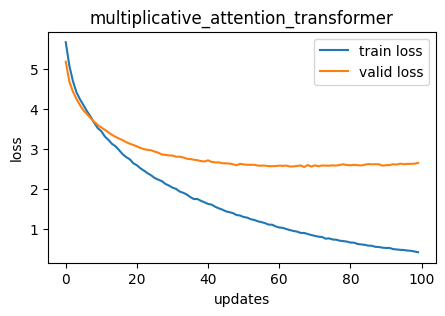

In [96]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
ax.set_title('multiplicative_attention_transformer')

filename = './app/images/multiplicative_attention_transformer_loss_plot.png'

# Save the figure
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')

In [53]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion_multi, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.617 | Test PPL:  13.695 |


#### - additive attention

In [54]:
model = initialize_model("additive_attention")

import torch.optim as optim

#training hyperparameters
lr = 0.0001
optimizer_add = optim.Adam(model.parameters(), lr=lr)
criterion_add = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

print(count_parameters(model))

196096
256000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
136448
256000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072

In [55]:
best_valid_loss = float('inf')
best_train_loss = float('inf')
best_train_ppl  = float('inf')
best_valid_ppl  = float('inf')

num_epochs = 100
clip = 1
save_path = './app/models/additive_attention.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer_add, criterion_add, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion_add, val_loader_length)
    
    # For plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_ppl = train_ppl
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_ppl = valid_ppl
        torch.save(model.state_dict(), save_path)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

print(f'Best Train Loss: {best_train_loss:.3f} | Best Train PPL: {best_train_ppl:7.3f}')
print(f'Best Val. Loss: {best_valid_loss:.3f} | Best Val. PPL: {best_valid_ppl:7.3f}')

Epoch: 01 | Time: 0m 0s
	Train Loss: 5.661 | Train PPL: 287.307
	 Val. Loss: 5.173 |  Val. PPL: 176.467
Epoch: 02 | Time: 0m 0s
	Train Loss: 5.079 | Train PPL: 160.545
	 Val. Loss: 4.684 |  Val. PPL: 108.175
Epoch: 03 | Time: 0m 0s
	Train Loss: 4.695 | Train PPL: 109.387
	 Val. Loss: 4.432 |  Val. PPL:  84.072
Epoch: 04 | Time: 0m 0s
	Train Loss: 4.416 | Train PPL:  82.730
	 Val. Loss: 4.252 |  Val. PPL:  70.251
Epoch: 05 | Time: 0m 0s
	Train Loss: 4.238 | Train PPL:  69.292
	 Val. Loss: 4.091 |  Val. PPL:  59.798
Epoch: 06 | Time: 0m 0s
	Train Loss: 4.089 | Train PPL:  59.683
	 Val. Loss: 3.961 |  Val. PPL:  52.489
Epoch: 07 | Time: 0m 0s
	Train Loss: 3.937 | Train PPL:  51.271
	 Val. Loss: 3.866 |  Val. PPL:  47.729
Epoch: 08 | Time: 0m 0s
	Train Loss: 3.803 | Train PPL:  44.821
	 Val. Loss: 3.768 |  Val. PPL:  43.299
Epoch: 09 | Time: 0m 0s
	Train Loss: 3.651 | Train PPL:  38.525
	 Val. Loss: 3.679 |  Val. PPL:  39.615
Epoch: 10 | Time: 0m 0s
	Train Loss: 3.519 | Train PPL:  33.759


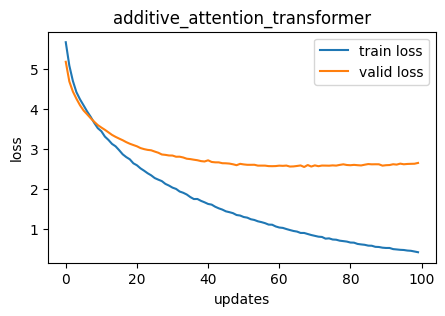

In [97]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
ax.set_title('additive_attention_transformer')

filename = './app/images/additive_attention_transformer_loss_plot.png'

# Save the figure
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')

In [57]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion_add, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.600 | Test PPL:  13.463 |


# 5. Inferencing on random sentences

In [58]:
def translate_sentence(model, sentence, max_len=50):
    model.eval()
    
    # Tokenize the source sentence if it's not already tokenized
    if isinstance(sentence, str):
        tokens = [token.lower() for token in token_transform[SRC_LANGUAGE](sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    # Numericalize the tokens using the vocabulary
    tokens = [SOS_IDX] + [vocab_transform[SRC_LANGUAGE].get_stoi()[token] 
                          if token in vocab_transform[SRC_LANGUAGE].get_stoi() else UNK_IDX for token in tokens] + [EOS_IDX]
    src_indexes = torch.LongTensor(tokens).to(device)
    src_indexes = src_indexes.reshape(1,-1)
    
    # Create a source mask
    src_mask = model.make_src_mask(src_indexes)
    
    with torch.no_grad():
        enc_src = model.encoder(src_indexes, src_mask)
    
    trg_indexes = [SOS_IDX]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)
        
        if pred_token == EOS_IDX:
            break
    
    trg_tokens = [vocab_transform[TRG_LANGUAGE].get_itos()[i] for i in trg_indexes]
    
    return trg_tokens, attention  

In [59]:
generalTransformer = initialize_model('general_attention')
generalTransformer.load_state_dict(torch.load('./app/models/general_attention.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [60]:
multiplicativeTransformer = initialize_model('multiplicative_attention')
multiplicativeTransformer.load_state_dict(torch.load('./app//models/multiplicative_attention.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [61]:
additiveTransformer = initialize_model('additive_attention')
additiveTransformer.load_state_dict(torch.load('./app/models/additive_attention.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [86]:
english_sentence_1 = 'who are they'

myanmar_sentence_1_gen, general_attention_map = translate_sentence(generalTransformer, english_sentence_1 ,max_len=100)
print('trnsformer_with_gnrl_attention: ', ''.join(myanmar_sentence_1_gen[1:-1]))# Remove <sos> and <eos> tokens before returning
myanmar_sentence_1_multi, multiplicative_attention_map = translate_sentence(multiplicativeTransformer, english_sentence_1, max_len=100)
print('transformer_with_multi_attention: ', ''.join(myanmar_sentence_1_multi[1:-1]))
myanmar_sentence_1_add, additive_attention_map = translate_sentence(additiveTransformer, english_sentence_1,max_len=100)
print('transformer_with_add_attention: ', ''.join(myanmar_sentence_1_add[1:-1]))

trnsformer_with_gnrl_attention:  ဒီနေ့လယ်ကဈေးသက်သာနဲ့ဝယ်မယ်။
transformer_with_multi_attention:  ကျွန်တော်ဒီဟင်းကဟင်းရွက်တွေက<unk>တယ်။
transformer_with_add_attention:  အဲဒီလူကဘယ်လိုရှိတယ်။


In [89]:
english_sentence_2 = 'there will be no class'

myanmar_sentence_2_gen, general_attention_map= translate_sentence(generalTransformer, english_sentence_2, max_len=100)
print('trnsformer_with_gnrl_attention: ',''.join(myanmar_sentence_2_gen[1:-1]))
myanmar_sentence_2_multi, multiplicative_attention_map= translate_sentence(multiplicativeTransformer, english_sentence_2, max_len=100)
print('transformer_with_multi_attention: ',''.join(myanmar_sentence_2_multi[1:-1]))
myanmar_sentence_2_add, additive_attention_map= translate_sentence(additiveTransformer, english_sentence_2, max_len=100)
print('transformer_with_add_attention: ', ''.join(myanmar_sentence_2_add[1:-1]))

trnsformer_with_gnrl_attention:  ဒီမှာအတန်းမရှိဘူး။
transformer_with_multi_attention:  ဒီမနက်ကအတန်းထဲမှာရှိလို့ရမယ်။
transformer_with_add_attention:  ဒီအတန်းကနေမယ်။


In [93]:
english_sentence_3 = 'I go outside to eat'

myanmar_sentence_3_gen, general_attention_map= translate_sentence(generalTransformer, english_sentence_3, max_len=100)
print('trnsformer_with_gnrl_attention: ',''.join(myanmar_sentence_3_gen[1:-1]))
myanmar_sentence_3_multi, multiplicative_attention_map= translate_sentence(multiplicativeTransformer, english_sentence_3, max_len=100)
print('transformer_with_multi_attention: ', ''.join(myanmar_sentence_3_multi[1:-1]))
myanmar_sentence_3_add, additive_attention_map= translate_sentence(additiveTransformer, english_sentence_3, max_len=100)
print('transformer_with_add_attention: ', ''.join(myanmar_sentence_3_add[1:-1]))

trnsformer_with_gnrl_attention:  အပြင်ထွက်လို့ရနဲ့တွေ့ပြီးစားတယ်။
transformer_with_multi_attention:  အပြင်ထွက်လို့ရမလား။
transformer_with_add_attention:  အပြင်ထွက်လို့ဘာယာရှိတယ်။


# 6. Attention maps

In [70]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [103]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def display_attention(sentence, translation, attention, filename):
    
    attention = attention.squeeze(0).mean(0) 
    # (1, num_heads, trg_len, src_len)

    if isinstance(sentence, str):
        sentence = sentence.split()  # Tokenize the sentence if it's a single string
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks, name = 'Noto Sans Myanmar')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

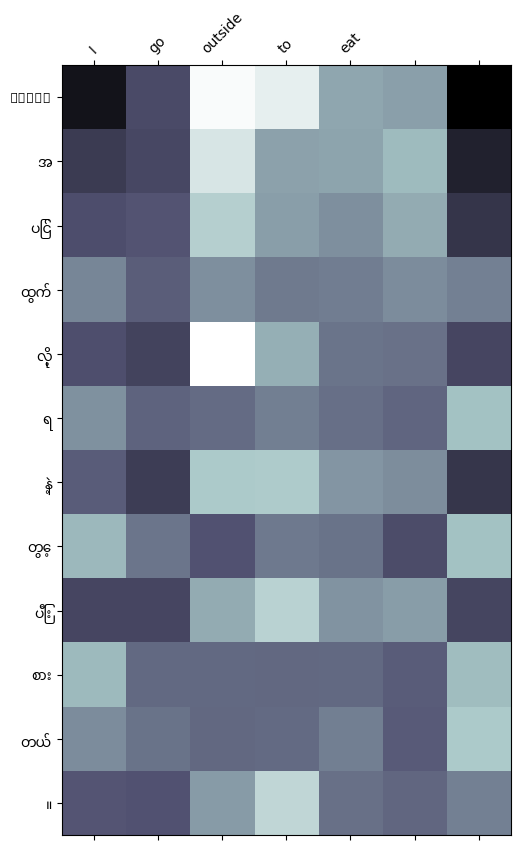

In [104]:
display_attention(english_sentence_3, myanmar_sentence_3_gen, general_attention_map, './app/images/general_attention_map.png')

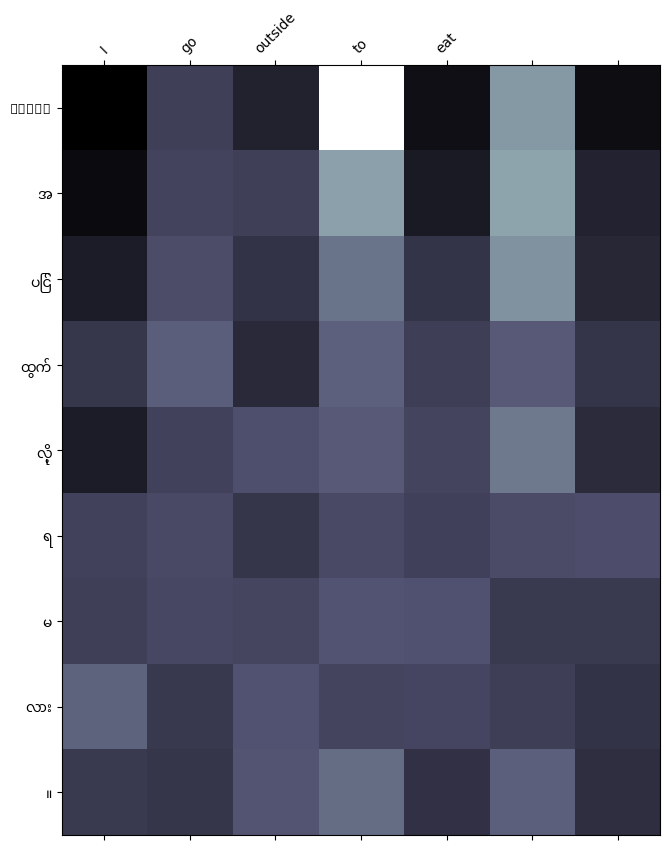

In [105]:
display_attention(english_sentence_3, myanmar_sentence_3_multi, multiplicative_attention_map, './app/images/multiplicative_attention_map.png')

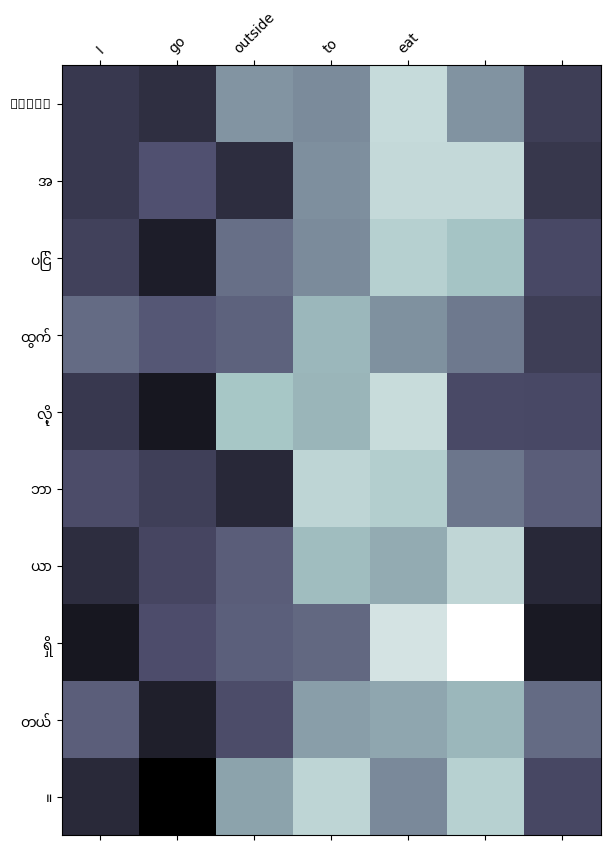

In [106]:
display_attention(english_sentence_3, myanmar_sentence_3_add, additive_attention_map, './app/images/additive_attention_map.png')